In [1]:
import os
import sys
import torch
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader

# ========== Add src/ to path if needed ==========
sys.path.append(os.path.join(os.getcwd(), 'src'))

# ========== Imports from project ==========
from dataloader import SatelliteDataset, NUM_GATEWAYS
from model2 import Stage2GNN
from train2 import train_model_with_coverage
from utils import plot_metrics, build_gateway_to_cells_mapping


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa

✅ Loaded 8 training files and 2 validation files.
✅ Loaded gateway-to-cell mapping with 54 gateways covering 4569 cells.
[Epoch 02] Train Loss: 3.8893 | Val Loss: 3.9407 | Top-1: 0.072 / 0.205
[Epoch 04] Train Loss: 3.5441 | Val Loss: 3.4962 | Top-1: 0.250 / 0.302
[Epoch 06] Train Loss: 3.1871 | Val Loss: 3.1068 | Top-1: 0.349 / 0.340
[Epoch 08] Train Loss: 2.8207 | Val Loss: 2.7750 | Top-1: 0.396 / 0.352
[Epoch 10] Train Loss: 2.5123 | Val Loss: 2.5626 | Top-1: 0.422 / 0.332
[Epoch 12] Train Loss: 2.2901 | Val Loss: 2.4535 | Top-1: 0.440 / 0.375
[Epoch 14] Train Loss: 2.1520 | Val Loss: 2.4229 | Top-1: 0.457 / 0.378
[Epoch 16] Train Loss: 2.0798 | Val Loss: 2.4314 | Top-1: 0.475 / 0.380
[Epoch 18] Train Loss: 2.0292 | Val Loss: 2.4637 | Top-1: 0.491 / 0.396
[Epoch 20] Train Loss: 1.9764 | Val Loss: 2.4953 | Top-1: 0.512 / 0.382


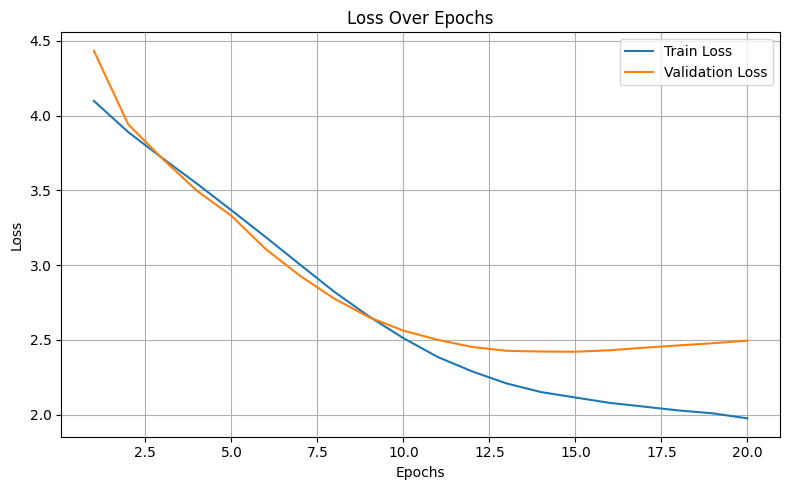

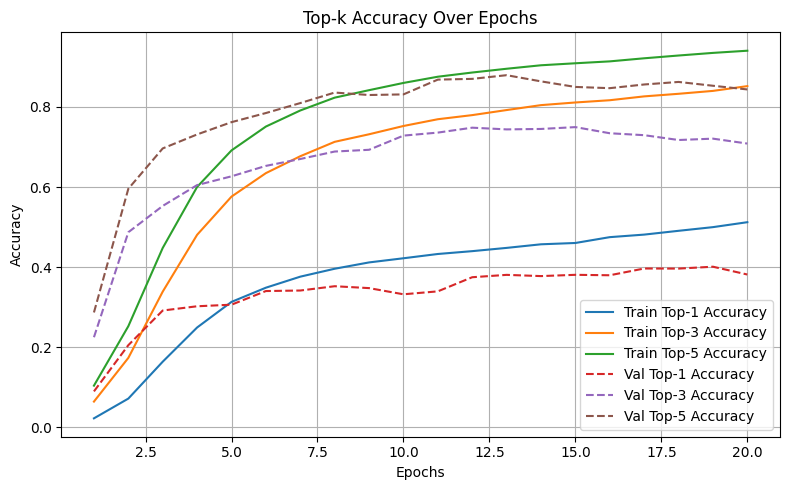

✅ GNN model saved with coverage-aware training.


In [2]:

# ========== Load Dataset ==========
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"

file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:10]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Loaded {len(train_files)} training files and {len(val_files)} validation files.")

# ========== Load Stage 1 Model ==========
STAGE1_MODEL_PATH = 'stage_1_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

# ========== Build Gateway-to-Cell Mapping ==========
GATEWAY_CELL_CSV = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
gw_to_cells = build_gateway_to_cells_mapping(GATEWAY_CELL_CSV)
# Count unique cell indices across all gateways
total_cells = len(set(cell for cells in gw_to_cells.values() for cell in cells))



print(f"✅ Loaded gateway-to-cell mapping with {len(gw_to_cells)} gateways covering {total_cells} cells.")

# ========== Build GNN Model ==========
input_dim = 3 + NUM_GATEWAYS * 3  # position + visibility + top3 gateways + neighbors
gnn_model = Stage2GNN(
    input_dim=input_dim,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)

optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.001)

# ========== Train with Coverage-Aware Loss ==========
results = train_model_with_coverage(
    gnn_model=gnn_model,
    stage1_model=stage1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_gnn=optimizer_gnn,
    gw_to_cells=gw_to_cells,              # NOTE: updated argument
    total_cells=total_cells,
    num_epochs=20,
    rounds=15,
    lambda_global=0.2,
    lambda_entropy=0.01,
    lambda_coverage=1.0,
    label_smoothing=0.1
)

(train_losses, val_losses,
 train_top1_acc, train_top3_acc, train_top5_acc,
 val_top1_acc, val_top3_acc, val_top5_acc) = results

# ========== Plot ==========
plot_metrics(train_losses, val_losses,
             train_top1_acc, train_top3_acc, train_top5_acc,
             val_top1_acc, val_top3_acc, val_top5_acc)

# ========== Save ==========
torch.save(gnn_model.state_dict(), 'stage2_loop_gnn_model_with_coverage.pth')
print("✅ GNN model saved with coverage-aware training.")


In [4]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model2 import Stage2GNN  # use model2 for coverage-aware model

# Constants
NUM_GATEWAYS = 54  # Define this according to your setup

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'

# Load Stage 1 model
stage1_model = load_model(STAGE1_MODEL_PATH)

# Initialize and load the GNN model
input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(
    input_dim=input_dim,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# List all .csv files
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])

# Define test ranges
test_ranges = {
    "Train Range 0-5": (0, 5),
    "Train Range 5-10": (5, 10),
    "Test Range 11-15": (11, 15),
    "Test Range 200-205": (200, 205)
}

# Function to evaluate test datasets
def evaluate_test_set(name, start, end):
    print(f"\n===== Evaluating {name} (Files {start} to {end}) =====")
    test_files = file_list[start:end]
    test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
    test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

    total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds_model1 = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_model1):
                binary_preds_model1[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
            preds = gnn_model(gnn_input.x, gnn_input.edge_index)

            total_top1 += top_k_accuracy(preds, data.y, k=1)
            total_top3 += top_k_accuracy(preds, data.y, k=3)
            total_top5 += top_k_accuracy(preds, data.y, k=5)
            total_samples += 1

            top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
            if isinstance(top1_pred, int):  # handle single-sample batch
                top1_pred = [top1_pred]

            for i in range(len(data.y)):
                predictions.append([data.y[i].item(), top1_pred[i]])

    print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
    print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
    print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

    results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
    filename = f"test_results_{name.replace(' ', '_').replace('-', '_')}_coverage.csv"
    results_df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Run evaluation for each test range
for name, (start, end) in test_ranges.items():
    evaluate_test_set(name, start, end)



===== Evaluating Train Range 0-5 (Files 0 to 5) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.5814
Top-3 Accuracy: 0.8872
Top-5 Accuracy: 0.9716
Saved predictions to test_results_Train_Range_0_5_coverage.csv

===== Evaluating Train Range 5-10 (Files 5 to 10) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.4901
Top-3 Accuracy: 0.8020
Top-5 Accuracy: 0.9066
Saved predictions to test_results_Train_Range_5_10_coverage.csv

===== Evaluating Test Range 11-15 (Files 11 to 15) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.4330
Top-3 Accuracy: 0.7713
Top-5 Accuracy: 0.8909
Saved predictions to test_results_Test_Range_11_15_coverage.csv

===== Evaluating Test Range 200-205 (Files 200 to 205) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.3733
Top-3 Accuracy: 0.6926
Top-5 Accuracy: 0.8126
Saved predictions to test_results_Test_Range_200_205_coverage.csv


Testing

Processing: file_data_10_00_00.csv
Processing: file_data_10_00_20.csv
Processing: file_data_10_00_40.csv
Processing: file_data_10_01_00.csv
Processing: file_data_10_01_20.csv
Processing: file_data_10_01_40.csv
Processing: file_data_10_02_00.csv
Processing: file_data_10_02_20.csv
Processing: file_data_10_02_40.csv
Processing: file_data_10_03_00.csv
Saved unused gateways per file to: unused_gateways_per_file_model2.csv

=== Overall Accuracy Summary ===
Top-1 Accuracy: 0.3484
Top-3 Accuracy: 0.7046
Top-5 Accuracy: 0.8195
Total Unique Gateways Predicted: 54


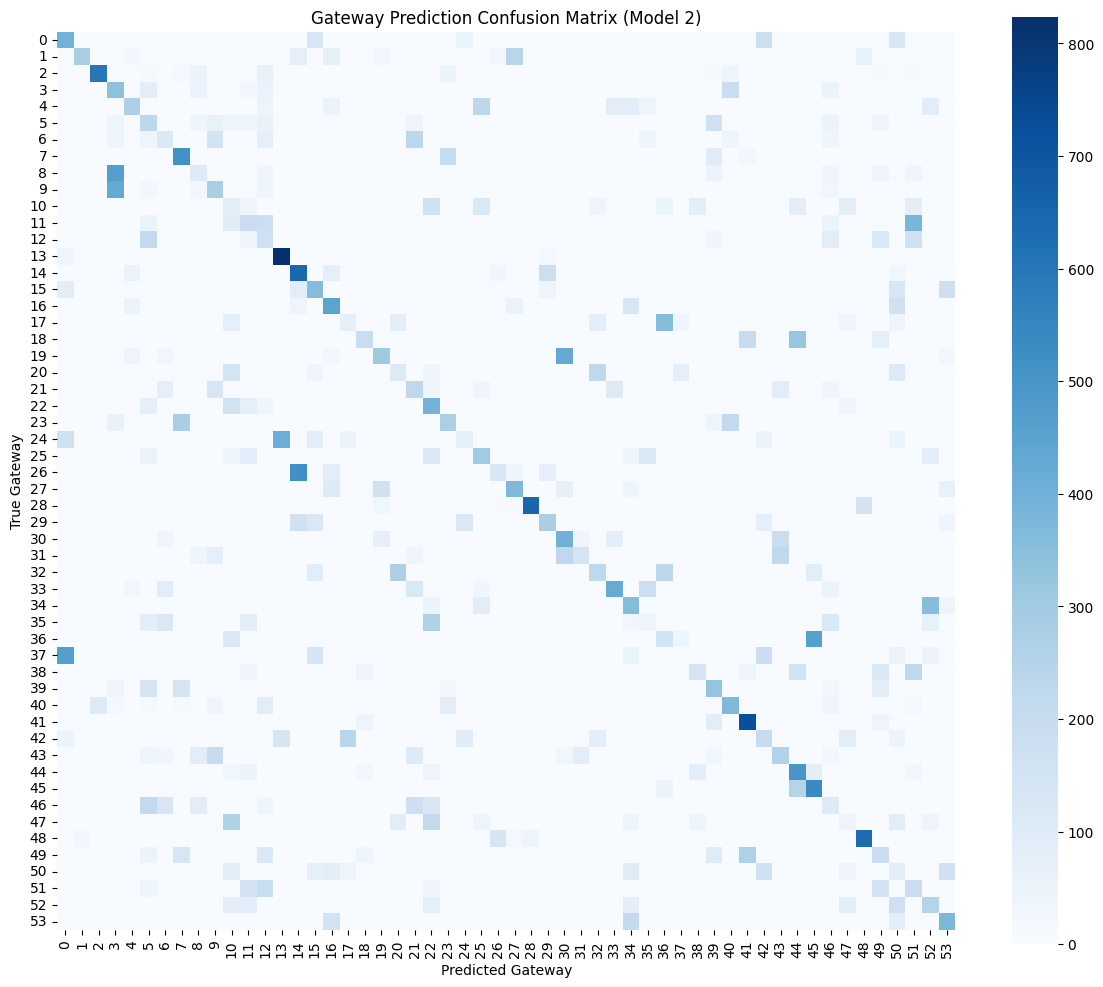


=== Unused Gateways ===
Total unused: 0
Gateways never predicted: []


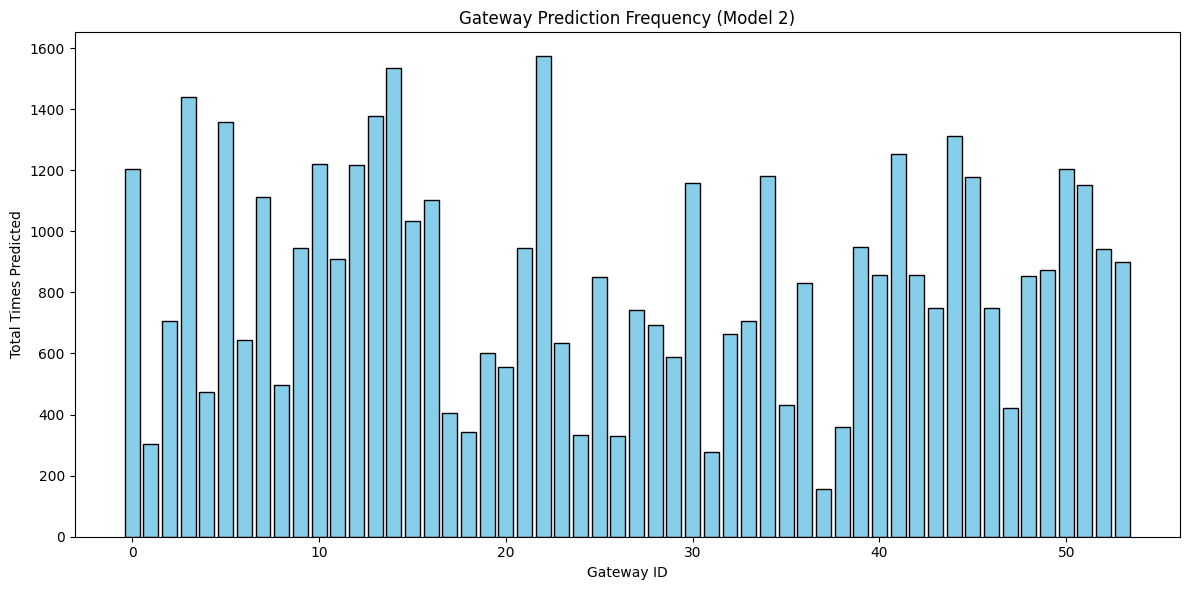

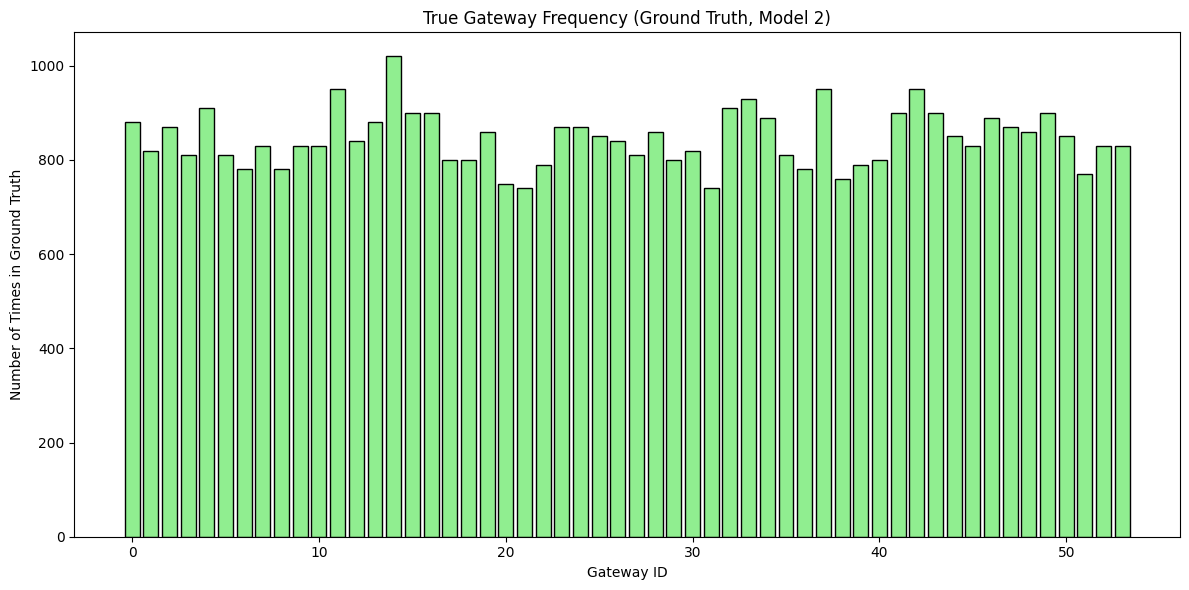

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torch_geometric.loader import DataLoader
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model2 import Stage2GNN  # UPDATED: use model2

# === Config ===
NUM_GATEWAYS = 54
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'  # UPDATED path

# === Load Models ===
stage1_model = load_model(STAGE1_MODEL_PATH)
gnn_model = Stage2GNN(input_dim=3 + NUM_GATEWAYS * 3, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
start_file = 'file_data_10_00_00.csv'
start_idx = all_files.index(start_file)
selected_files = all_files[start_idx:start_idx + 10]

# === Trackers ===
overall_top1, overall_top3, overall_top5 = 0, 0, 0
overall_samples = 0
gateway_correct_count = Counter()
gateway_total_count = Counter()
total_predicted_gw_counter = Counter()
per_file_stats = []
all_true_labels = []
all_pred_labels = []

# === Run Evaluation ===
for i, filename in enumerate(selected_files, start=1):
    filepath = os.path.join(DATA_FOLDER, filename)
    print(f"Processing: {filename}")

    graph = build_graph_from_file(filepath)
    if graph is None:
        print(f"Skipping {filename} (invalid graph)")
        continue

    loader = DataLoader([graph], batch_size=1, shuffle=False)
    file_top1, file_top3, file_top5 = 0, 0, 0
    file_gateway_counter = Counter()
    file_correct_preds = 0
    file_total_preds = 0

    with torch.no_grad():
        for data in loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds = np.zeros_like(stage1_preds)
            for j, idx in enumerate(top3_indices):
                binary_preds[j, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds, dtype=torch.float))
            preds = gnn_model(gnn_input.x, gnn_input.edge_index)

            top1 = top_k_accuracy(preds, data.y, k=1)
            top3 = top_k_accuracy(preds, data.y, k=3)
            top5 = top_k_accuracy(preds, data.y, k=5)

            overall_top1 += top1
            overall_top3 += top3
            overall_top5 += top5
            overall_samples += 1

            file_top1 += top1
            file_top3 += top3
            file_top5 += top5

            top1_preds = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
            if isinstance(top1_preds, int):
                top1_preds = [top1_preds]

            for j in range(len(data.y)):
                true_label = data.y[j].item()
                pred_label = top1_preds[j]
                all_true_labels.append(true_label)
                all_pred_labels.append(pred_label)

                gateway_total_count[true_label] += 1
                gateway_total_count[pred_label] += 0
                file_gateway_counter[pred_label] += 1
                total_predicted_gw_counter[pred_label] += 1
                if pred_label == true_label:
                    gateway_correct_count[pred_label] += 1
                    file_correct_preds += 1
                file_total_preds += 1

        acc = file_correct_preds / file_total_preds * 100
        predicted_gateways_set = set(file_gateway_counter.keys())
        missed_gateways = sorted(set(range(NUM_GATEWAYS)) - predicted_gateways_set)
        missed_percent = len(missed_gateways) / NUM_GATEWAYS * 100

        per_file_stats.append({
            'file': filename,
            'top1_acc': file_top1,
            'top3_acc': file_top3,
            'top5_acc': file_top5,
            'correct_preds': file_correct_preds,
            'total_preds': file_total_preds,
            'accuracy_percent': acc,
            'gateways_predicted': len(predicted_gateways_set),
            'gateways_missed': len(missed_gateways),
            'missed_gateway_ids': missed_gateways,
            'percent_gateways_missed': round(missed_percent, 2)
        })

# === Save Stats (MODEL 2 TAGGED) ===
stats_df = pd.DataFrame(per_file_stats)
stats_df.to_csv("gateway_prediction_stats_model2.csv", index=False)

unused_per_file = {
    'file': [],
    'unused_gateways': []
}

for entry in per_file_stats:
    unused_per_file['file'].append(entry['file'])
    unused_per_file['unused_gateways'].append(entry['missed_gateway_ids'])

unused_df = pd.DataFrame(unused_per_file)
unused_df.to_csv("unused_gateways_per_file_model2.csv", index=False)
print("Saved unused gateways per file to: unused_gateways_per_file_model2.csv")

# === Accuracy Summary ===
print("\n=== Overall Accuracy Summary ===")
print(f"Top-1 Accuracy: {overall_top1 / overall_samples:.4f}")
print(f"Top-3 Accuracy: {overall_top3 / overall_samples:.4f}")
print(f"Top-5 Accuracy: {overall_top5 / overall_samples:.4f}")
print(f"Total Unique Gateways Predicted: {len(total_predicted_gw_counter)}")

# === Confusion Matrix ===
cm = confusion_matrix(all_true_labels, all_pred_labels, labels=range(NUM_GATEWAYS))
cm_df = pd.DataFrame(cm, index=range(NUM_GATEWAYS), columns=range(NUM_GATEWAYS))
cm_df.to_csv("gateway_confusion_matrix_model2.csv")

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.title("Gateway Prediction Confusion Matrix (Model 2)")
plt.xlabel("Predicted Gateway")
plt.ylabel("True Gateway")
plt.tight_layout()
plt.savefig("gateway_confusion_matrix_model2.png", dpi=300)
plt.show()

# === Unused Gateways ===
all_gateways = set(range(NUM_GATEWAYS))
used_gateways = set(total_predicted_gw_counter.keys())
unused_gateways = sorted(all_gateways - used_gateways)

print("\n=== Unused Gateways ===")
print(f"Total unused: {len(unused_gateways)}")
print(f"Gateways never predicted: {unused_gateways}")
pd.Series(unused_gateways, name='unused_gateways').to_csv("unused_gateways_model2.csv", index=False)

# === Plot: Gateway Frequency ===
plt.figure(figsize=(12, 6))
sorted_keys = sorted(total_predicted_gw_counter.keys())
frequencies = [total_predicted_gw_counter[k] for k in sorted_keys]
plt.bar(sorted_keys, frequencies, color='skyblue', edgecolor='black')
plt.title("Gateway Prediction Frequency (Model 2)")
plt.xlabel("Gateway ID")
plt.ylabel("Total Times Predicted")
plt.tight_layout()
plt.savefig("gateway_prediction_histogram_model2.png", dpi=300)
plt.show()

# === Plot: Ground Truth Frequency ===
true_gateway_counter = Counter(all_true_labels)
sorted_true_keys = sorted(true_gateway_counter.keys())
true_frequencies = [true_gateway_counter[k] for k in sorted_true_keys]

plt.figure(figsize=(12, 6))
plt.bar(sorted_true_keys, true_frequencies, color='lightgreen', edgecolor='black')
plt.title("True Gateway Frequency (Ground Truth, Model 2)")
plt.xlabel("Gateway ID")
plt.ylabel("Number of Times in Ground Truth")
plt.tight_layout()
plt.savefig("gateway_truth_histogram_model2.png", dpi=300)
plt.show()


Test file - Greedy Cell Assignment Based on Satellite-Gateway Predictions"

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model2 import Stage2GNN  # UPDATED: use model2

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'  # UPDATED for Model 2

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

        for row_idx, gateway in enumerate(top1_preds):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            satellite_to_gateway[feed_sat] = gateway
            gateway_to_sats[gateway].append(feed_sat)

# === Fair Cell Assignment (Greedy) ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()

    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))
    n_sats = len(sats)
    cell_chunks = np.array_split(nearby_cells, n_sats)

    for sat, chunk in zip(sats, cell_chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

# === Print Summary ===
print("\n=== Summary (Model 2) ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Total Gateways: {NUM_GATEWAYS}")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")
print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results (Model 2) ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
    most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
    assigned = satellite_to_cells.get(sat_feed_val, [])

    assigned_clean = [int(cell) for cell in assigned]
    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping_00_00_00_model2.csv", index=False)

# === Output preview ===
print("\n=== Output File Preview (Model 2) ===")
print(output_df.head())


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



=== Summary (Model 2) ===
Unique Satellites: 112
Satellites With Assigned Cells: 91 (81.25%)
Satellites With No Assigned Cells: 21 (18.75%)
Gateways With Unassigned Cells: 7 (12.96%)
Total Gateways: 54
Used Gateways: 47 (87.04%)
Unused Gateways: [15, 18, 31, 32, 37, 51, 52]
Assigned Cells: 4545 / 4569 (99.47%)
Unassigned Cells: 24 (0.53%)

=== Output File Preview (Model 2) ===
   unique_satellite_id  predicted_gateway  actual_gateway_id  \
0                    5                  2                  2   
1                    7                 34                 34   
2                    8                 29                 29   
3                   28                  3                  2   
4                   29                  6                 21   

                                      assigned_cells  \
0                                                 []   
1  [1, 274, 312, 345, 399, 416, 445, 512, 586, 72...   
2  [92, 108, 163, 212, 303, 375, 440, 536, 598, 7...   
3         

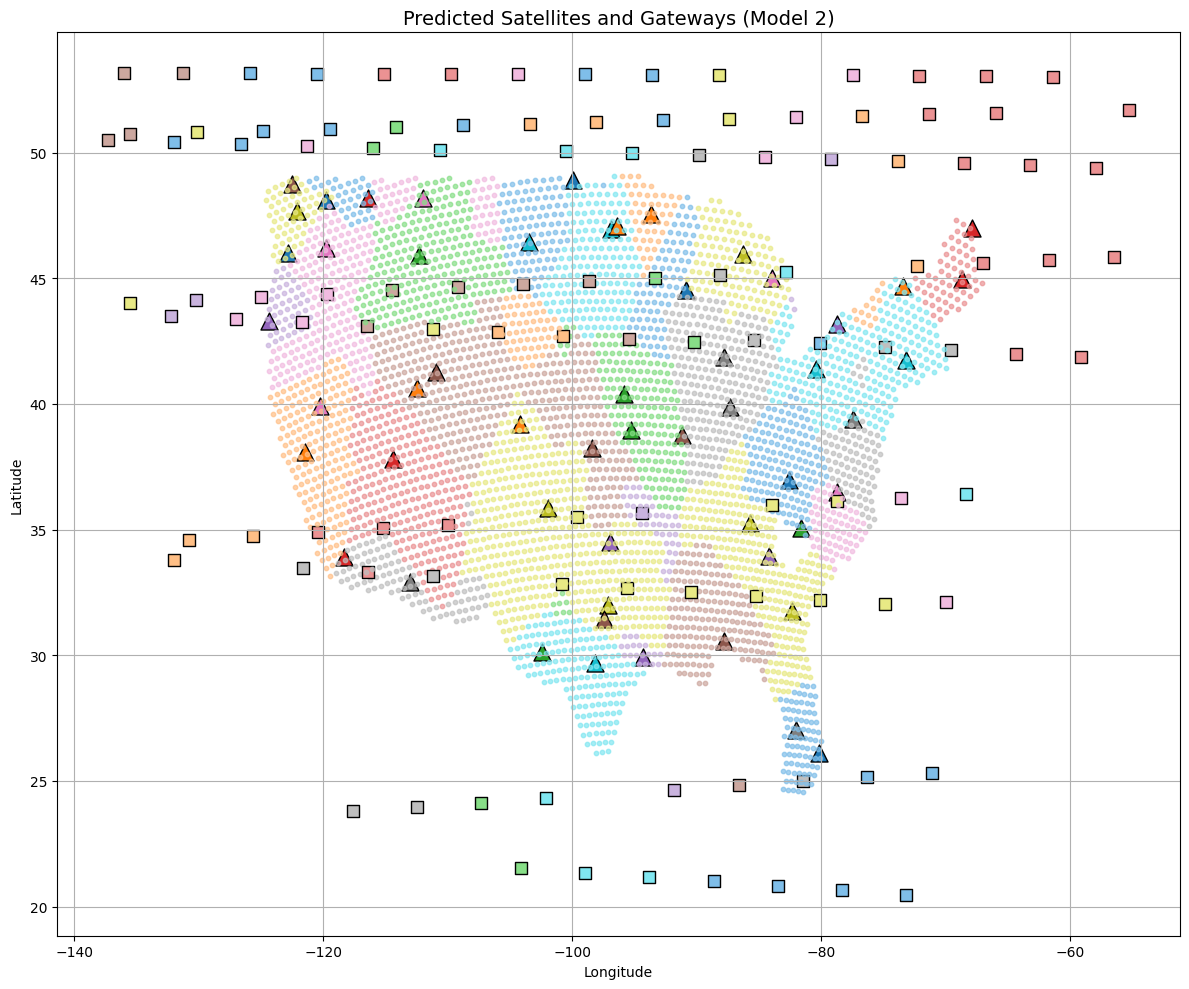

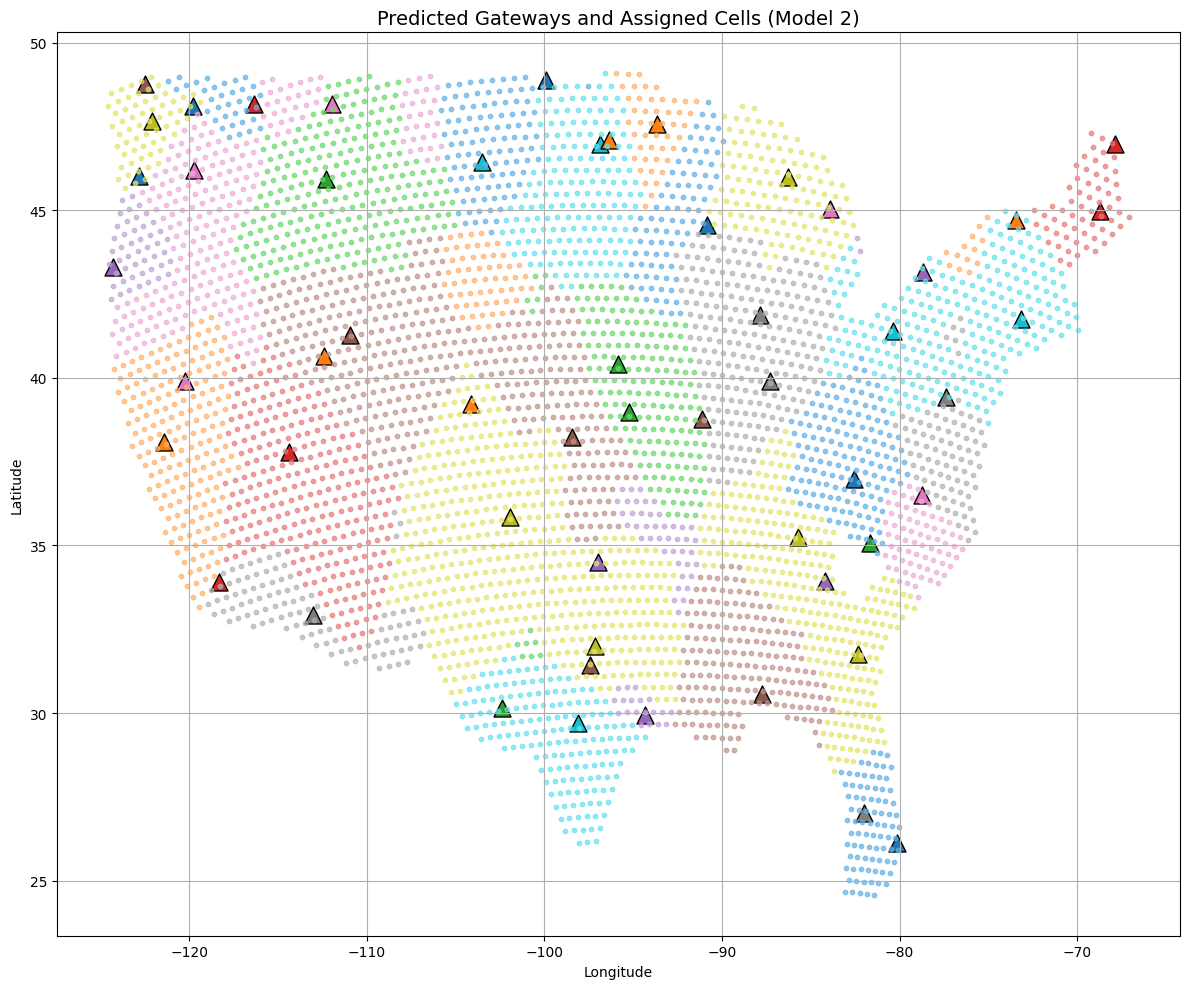

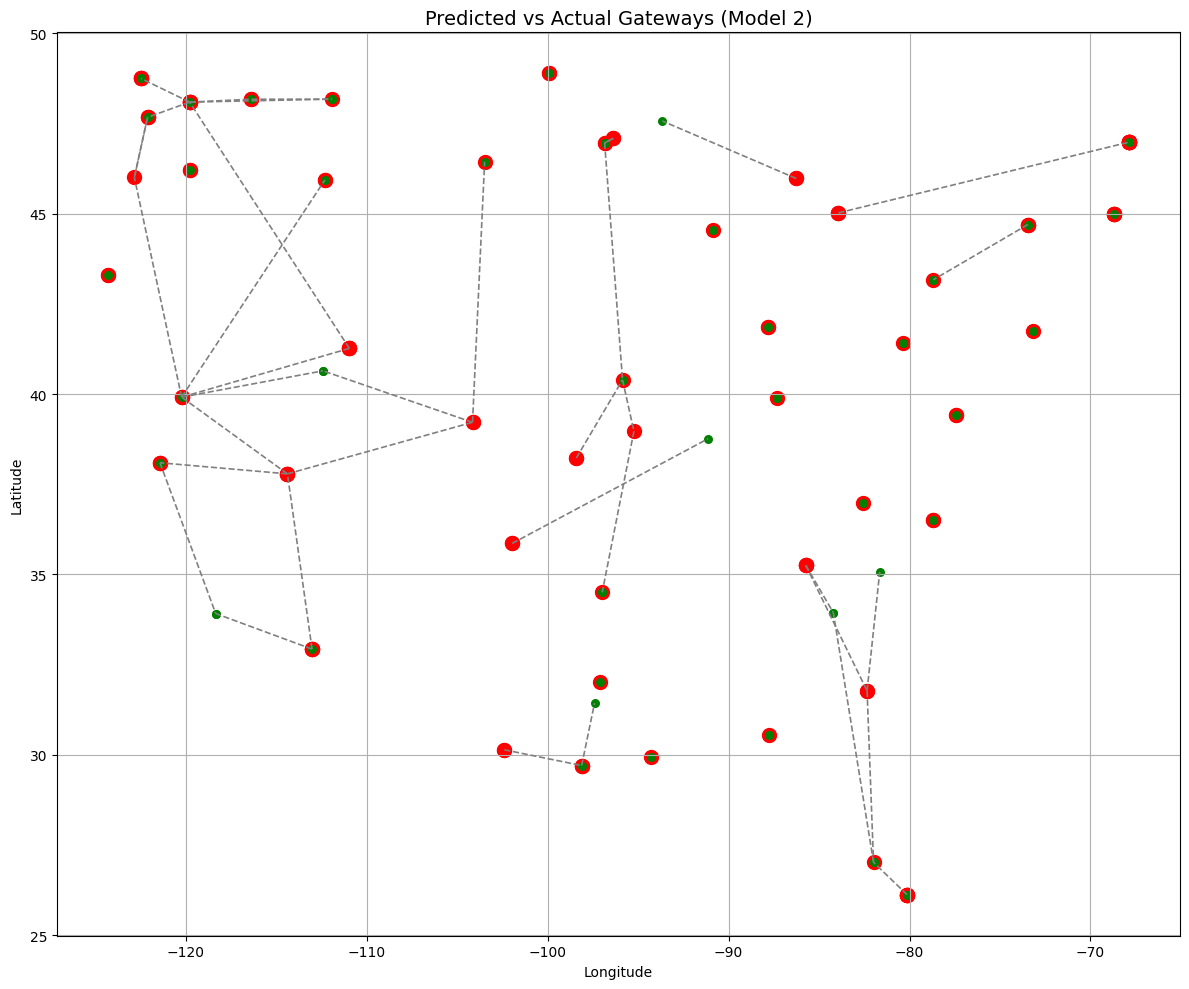

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping_00_00_00_model2.csv")  # UPDATED
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Setup Color Map ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)

gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helper: Lighter version of color ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

# === Parse list-like column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

# === Map 1: Predicted Satellites & Gateways (Model 2) ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)
    sat_row = sat_df[sat_df['feed_sat'] == sat_id]
    if not sat_row.empty:
        lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
        plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Satellites and Gateways (Model 2)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map1_predicted_satellites_and_gateways_model2.png", dpi=300)
plt.show()

# === Map 2: Predicted Gateways & Assigned Cells (Model 2) ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Gateways and Assigned Cells (Model 2)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map2_predicted_gateways_and_cells_model2.png", dpi=300)
plt.show()

# === Map 3: Predicted vs Actual Gateways (Model 2) ===
plt.figure(figsize=(12, 10))
for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    actual_gw = row['actual_gateway_id']

    pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
    actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

    if not pred_gw_row.empty and not actual_gw_row.empty:
        pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
        act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

        plt.scatter(pred_lng, pred_lat, color='red', s=100, label='Predicted Gateway')
        plt.scatter(act_lng, act_lat, color='green', s=30, label='Actual Gateway')
        plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

plt.title("Predicted vs Actual Gateways (Model 2)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map3_predicted_vs_actual_gateways_model2.png", dpi=300)
plt.show()


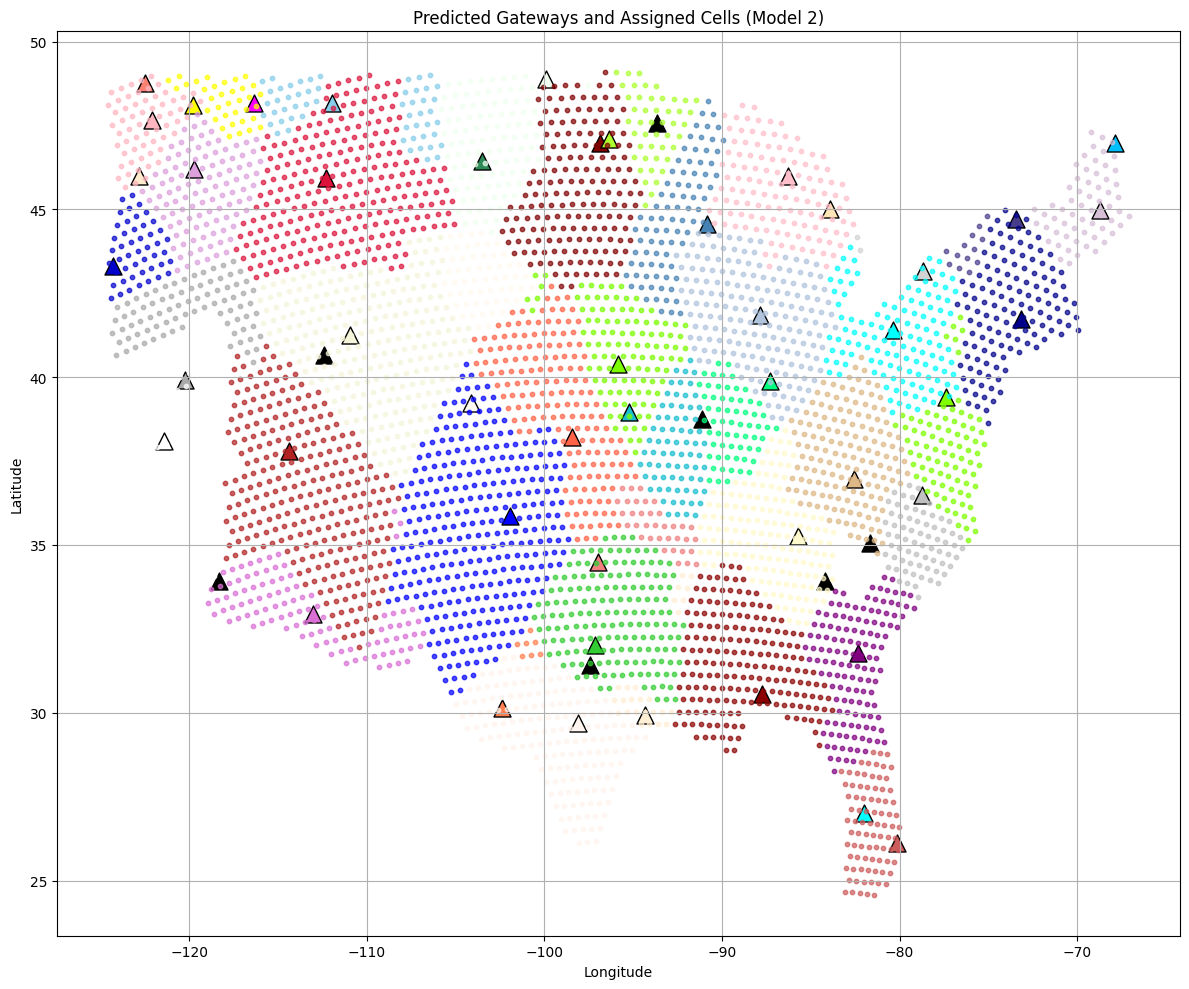

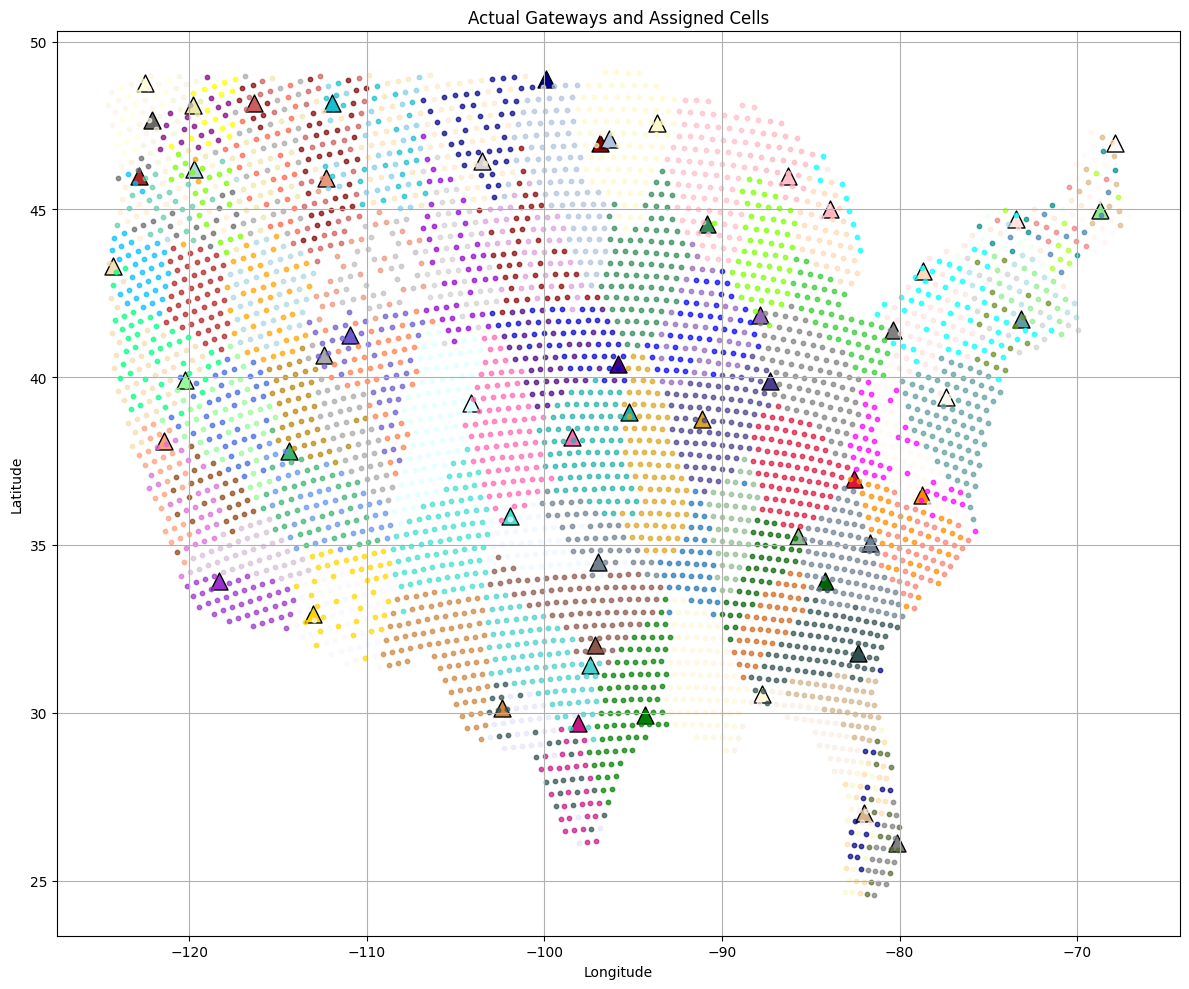

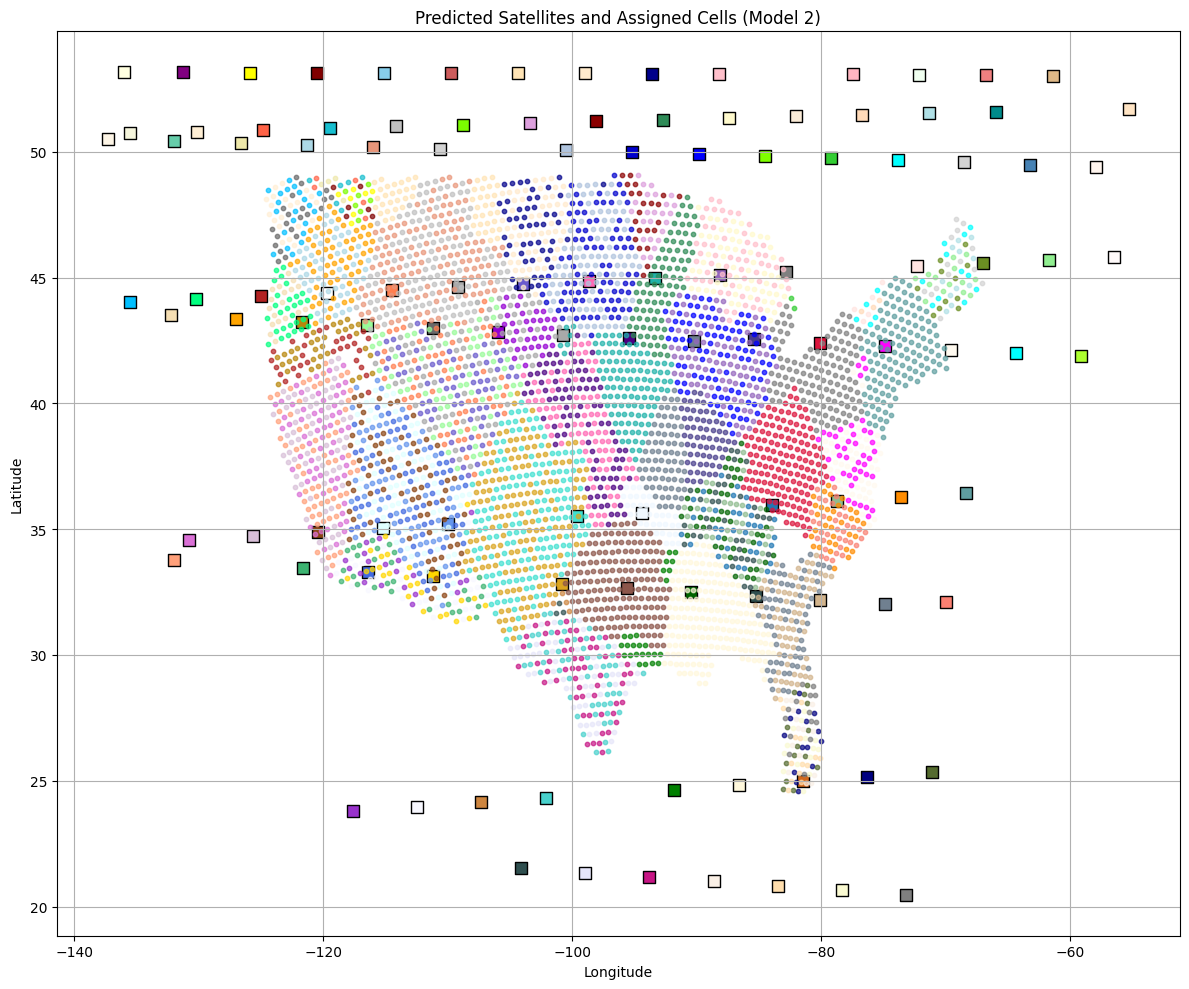

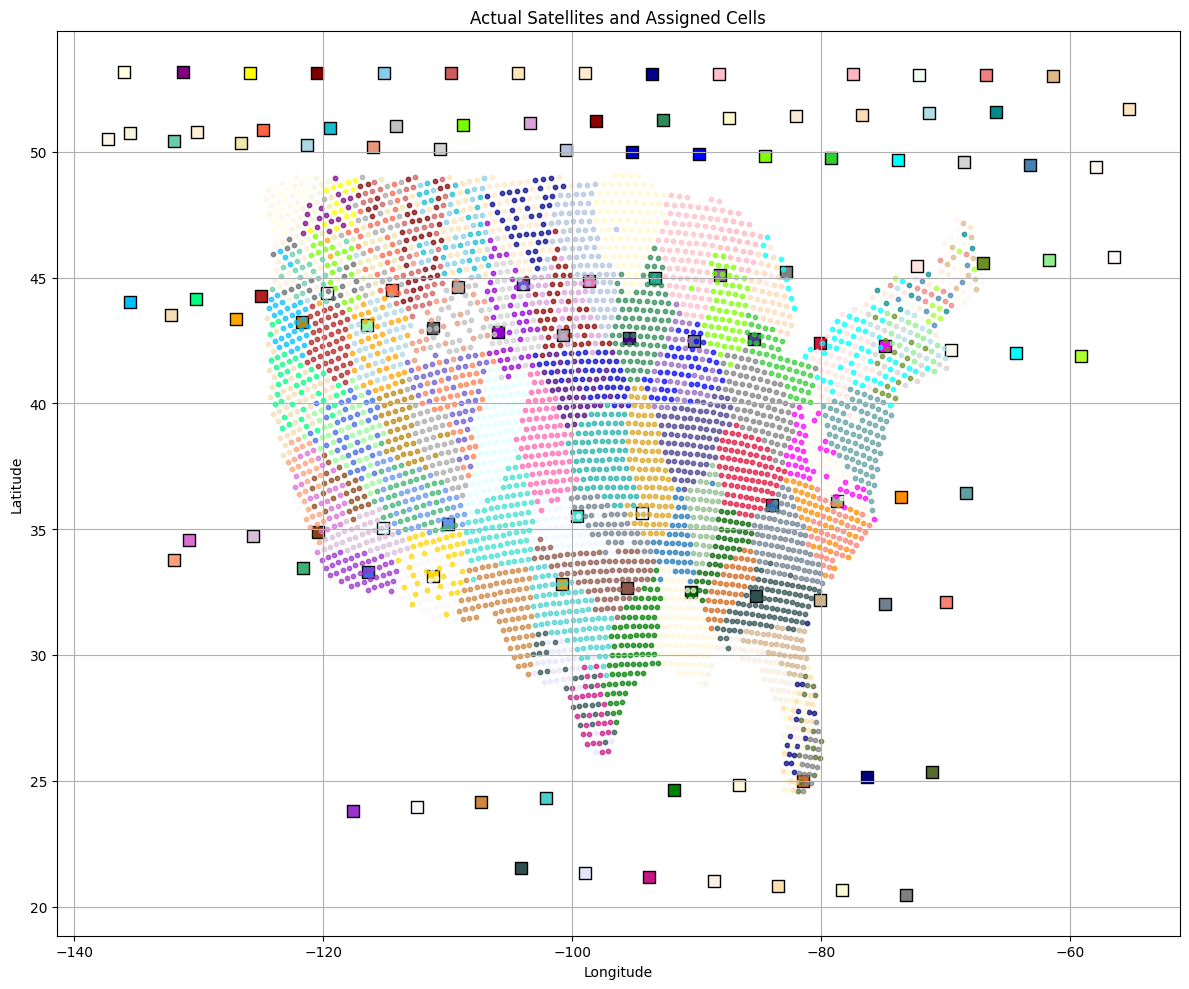

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
pred_df = pd.read_csv("satellite_to_cells_mapping_00_00_00_model2.csv")  # UPDATED
actual_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_positions = actual_df.drop_duplicates(subset='feed_sat')[['feed_sat', 'Longitude', 'Latitude']]

# === Helper: Parse assigned_cells column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

pred_df['assigned_cells'] = pred_df['assigned_cells'].apply(parse_cells)

# === Color Map Setup ===
base_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)

def safe_color(idx):
    return base_colors[idx % len(base_colors)]

# === Actual Assignments ===
actual_sat_to_cells = actual_df.groupby('feed_sat')['cell_id'].apply(list).to_dict()
actual_sat_to_gw = actual_df.groupby('feed_sat')['gw'].first().to_dict()

# === Map Plotting Function ===
def plot_assignment(title, sat_to_cells, sat_to_color, gateway_colors=None, show_sats=True, show_gateways=True, filename="map.png"):
    plt.figure(figsize=(12, 10))

    if show_gateways and gateway_colors:
        for _, row in gw_df.iterrows():
            gw_id = row['gw_id']
            color = gateway_colors.get(gw_id, 'black')
            plt.scatter(row['longitude'], row['latitude'], marker='^', color=color, edgecolor='black', s=150)

    if show_sats:
        for sat_id, color in sat_to_color.items():
            pos = sat_positions[sat_positions['feed_sat'] == sat_id]
            if not pos.empty:
                lng, lat = pos.iloc[0][['Longitude', 'Latitude']]
                plt.scatter(lng, lat, marker='s', color=color, edgecolor='black', s=80)

    for sat_id, cells in sat_to_cells.items():
        color = sat_to_color.get(sat_id, 'gray')
        for cell_id in cells:
            if cell_id in cells_df.index:
                lng, lat = cells_df.loc[cell_id, ['lng', 'lat']]
                plt.scatter(lng, lat, color=color, s=10, alpha=0.7)

    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# === 1. Predicted Gateways and Assigned Cells (Model 2) ===
sat_to_cells_pred = {row['unique_satellite_id']: row['assigned_cells'] for _, row in pred_df.iterrows()}
sat_to_gw_pred = {row['unique_satellite_id']: row['predicted_gateway'] for _, row in pred_df.iterrows()}
gw_to_color_pred = {gw: safe_color(i) for i, gw in enumerate(sorted(set(sat_to_gw_pred.values())))}
sat_to_color_pred_gw = {sat: gw_to_color_pred[gw] for sat, gw in sat_to_gw_pred.items()}

plot_assignment(
    title="Predicted Gateways and Assigned Cells (Model 2)",
    sat_to_cells=sat_to_cells_pred,
    sat_to_color=sat_to_color_pred_gw,
    gateway_colors=gw_to_color_pred,
    show_sats=False,
    show_gateways=True,
    filename="map1_predicted_gateways_cells_model2.png"  # UPDATED
)

# === 2. Actual Gateways and Assigned Cells (unchanged) ===
sat_to_color_actual_gw = {}
gw_to_color_actual = {}

for i, (sat, gw) in enumerate(actual_sat_to_gw.items()):
    color = safe_color(i)
    sat_to_color_actual_gw[sat] = color
    gw_to_color_actual[gw] = color

plot_assignment(
    title="Actual Gateways and Assigned Cells",
    sat_to_cells=actual_sat_to_cells,
    sat_to_color=sat_to_color_actual_gw,
    gateway_colors=gw_to_color_actual,
    show_sats=False,
    show_gateways=True,
    filename="map2_actual_gateways_cells_model2.png"  # UPDATED
)

# === 3. Predicted Satellites and Assigned Cells (Model 2) ===
sat_to_color_pred = {sat: safe_color(i) for i, sat in enumerate(sat_to_cells_pred)}
plot_assignment(
    title="Predicted Satellites and Assigned Cells (Model 2)",
    sat_to_cells=sat_to_cells_pred,
    sat_to_color=sat_to_color_pred,
    show_sats=True,
    show_gateways=False,
    filename="map3_predicted_satellites_cells_model2.png"  # UPDATED
)

# === 4. Actual Satellites and Assigned Cells (unchanged) ===
sat_to_color_actual = {sat: safe_color(i) for i, sat in enumerate(actual_sat_to_cells)}
plot_assignment(
    title="Actual Satellites and Assigned Cells",
    sat_to_cells=actual_sat_to_cells,
    sat_to_color=sat_to_color_actual,
    show_sats=True,
    show_gateways=False,
    filename="map4_actual_satellites_cells_model2.png"  # UPDATED
)


In [8]:
import pandas as pd

# === Load Files ===
pred_df = pd.read_csv("satellite_to_cells_mapping_00_00_00_model2.csv")  # UPDATED
actual_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")

# === Parse assigned_cells column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

pred_df['assigned_cells'] = pred_df['assigned_cells'].apply(parse_cells)

# === Gateway Statistics ===
actual_gateways = set(actual_df['gw'].unique())
predicted_gateways = set(pred_df['predicted_gateway'].unique())

missing_predicted_gateways = actual_gateways - predicted_gateways
extra_predicted_gateways = predicted_gateways - actual_gateways

# === Cell Statistics ===
actual_cells = set(actual_df['cell_id'].unique())
predicted_cells = set(cell for sublist in pred_df['assigned_cells'] for cell in sublist)

missing_predicted_cells = actual_cells - predicted_cells
extra_predicted_cells = predicted_cells - actual_cells

# === Reporting ===
print("\n=== 🔌 Gateway Usage Statistics (Model 2) ===")
print(f"Total Actual Gateways Used: {len(actual_gateways)}")
print(f"Total Predicted Gateways Used: {len(predicted_gateways)}")
print(f"Missing Predicted Gateways: {len(missing_predicted_gateways)} ({len(missing_predicted_gateways) / len(actual_gateways) * 100:.2f}%) → {sorted(missing_predicted_gateways)}")
print(f"Extra Predicted Gateways (not in actual): {len(extra_predicted_gateways)} → {sorted(extra_predicted_gateways)}")

print("\n=== 📡 Cell Assignment Statistics (Model 2) ===")
print(f"Total Actual Unique Cells: {len(actual_cells)}")
print(f"Total Predicted Assigned Cells: {len(predicted_cells)}")
print(f"Missing Predicted Cells: {len(missing_predicted_cells)} ({len(missing_predicted_cells) / len(actual_cells) * 100:.2f}%)")
print(f"Extra Predicted Cells (not in actual): {len(extra_predicted_cells)}")

# === Save to file (Model 2)
stats_df = pd.DataFrame([{
    "actual_gateways_used": len(actual_gateways),
    "predicted_gateways_used": len(predicted_gateways),
    "missing_gateways": len(missing_predicted_gateways),
    "missing_gateways_pct": len(missing_predicted_gateways) / len(actual_gateways) * 100,
    "extra_predicted_gateways": len(extra_predicted_gateways),

    "actual_cells": len(actual_cells),
    "predicted_cells": len(predicted_cells),
    "missing_cells": len(missing_predicted_cells),
    "missing_cells_pct": len(missing_predicted_cells) / len(actual_cells) * 100,
    "extra_predicted_cells": len(extra_predicted_cells)
}])

stats_df.to_csv("prediction_vs_actual_stats_model2.csv", index=False)  # UPDATED



=== 🔌 Gateway Usage Statistics (Model 2) ===
Total Actual Gateways Used: 54
Total Predicted Gateways Used: 47
Missing Predicted Gateways: 7 (12.96%) → [np.int64(15), np.int64(18), np.int64(31), np.int64(32), np.int64(37), np.int64(51), np.int64(52)]
Extra Predicted Gateways (not in actual): 0 → []

=== 📡 Cell Assignment Statistics (Model 2) ===
Total Actual Unique Cells: 4569
Total Predicted Assigned Cells: 4545
Missing Predicted Cells: 24 (0.53%)
Extra Predicted Cells (not in actual): 0


In [9]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model2 import Stage2GNN  # ✅ UPDATED

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'  # ✅ UPDATED

# === Load Base Data ===
cells_df = pd.read_csv(cells_path)
total_cells = len(cells_df)
all_cell_indices = set(cells_df.index)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
selected_files = all_files[:10]  # process first 10 files

# === Global Trackers ===
global_covered_cells = set()
coverage_results = []

# === Loop Over Files ===
for file_num, data_file in enumerate(selected_files, start=1):
    print(f"\n=== Processing File {file_num}: {os.path.basename(data_file)} ===")

    original_df = pd.read_csv(data_file)
    unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
    feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
    sat_to_indices = defaultdict(list)
    for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
        sat_to_indices[feed_sat].append(row_idx)

    satellite_to_gateway = {}
    gateway_to_sats = defaultdict(list)
    cell_to_gateways = {}
    for idx, row in cells_df.iterrows():
        cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

    graph = build_graph_from_file(data_file)
    data_loader = DataLoader([graph], batch_size=1)

    # === Model Inference ===
    top1_preds = []
    with torch.no_grad():
        for data in data_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_indices):
                binary_preds[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
            gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
            top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

            for row_idx, gateway in enumerate(top1_preds):
                feed_sat = original_df.iloc[row_idx]["feed_sat"]
                satellite_to_gateway[feed_sat] = gateway
                gateway_to_sats[gateway].append(feed_sat)

    # === Fair Cell Assignment ===
    satellite_to_cells = defaultdict(list)
    assigned_cells = set()
    used_gateways = set()

    for gw, sats in gateway_to_sats.items():
        nearby_cells = cells_df[
            (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
        ].index.tolist()

        if not sats or not nearby_cells:
            continue

        used_gateways.add(gw)
        sats = list(set(sats))
        n_sats = len(sats)
        cell_chunks = np.array_split(nearby_cells, n_sats)

        for sat, chunk in zip(sats, cell_chunks):
            for cell in chunk:
                if cell not in assigned_cells:
                    satellite_to_cells[sat].append(cell)
                    assigned_cells.add(cell)

    # === Track global coverage ===
    global_covered_cells.update(assigned_cells)
    file_coverage = len(assigned_cells) / total_cells * 100

    # === Summary ===
    total_unique_sats = len(unique_sats)
    assigned_sat_ids = set(satellite_to_cells.keys())
    unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
    all_gateways = set(range(NUM_GATEWAYS))
    unused_gateways = sorted(all_gateways - used_gateways)
    unassigned_cells = sorted(all_cell_indices - assigned_cells)

    print(f"Unique Satellites: {total_unique_sats}")
    print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({file_coverage:.2f}% coverage)")
    print(f"Used Gateways: {len(used_gateways)} / {NUM_GATEWAYS}")
    print(f"Unassigned Cells: {len(unassigned_cells)}")

    coverage_results.append({
        "file": os.path.basename(data_file),
        "assigned_cells": len(assigned_cells),
        "coverage_percent": file_coverage
    })

    # === Save Per-File Predictions ===
    output_rows = []
    all_sat_ids = sorted(feed_sat_to_id.keys())
    for sat_feed_val in all_sat_ids:
        row_indices = sat_to_indices.get(sat_feed_val, [])
        predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
        most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
        assigned = satellite_to_cells.get(sat_feed_val, [])
        assigned_clean = [int(cell) for cell in assigned]
        actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
        actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

        output_rows.append({
            "unique_satellite_id": sat_feed_val,
            "predicted_gateway": most_common_gateway,
            "actual_gateway_id": actual_gateway,
            "assigned_cells": assigned_clean,
            "actual_cell_ids": actual_cell_ids
        })

    output_df = pd.DataFrame(output_rows)
    output_csv_path = f"satellite_to_cells_mapping_file{file_num}_model2.csv"  # ✅ UPDATED
    output_df.to_csv(output_csv_path, index=False)

# === Global Coverage Summary ===
print("\n=== Global Summary Across Files (Model 2) ===")
print(f"Total Unique Cells: {total_cells}")
print(f"Cells Covered In Any File: {len(global_covered_cells)}")
print(f"Overall Coverage: {len(global_covered_cells) / total_cells * 100:.2f}%")

# === Unassigned Cells Across All Files ===
global_unassigned_cells = sorted(all_cell_indices - global_covered_cells)

print("\n=== Cells Never Assigned in Any File ===")
print(f"Total Unassigned Cells: {len(global_unassigned_cells)}")
print(f"Sample Unassigned Cell Indices: {global_unassigned_cells[:20]}")

# === Save Unassigned Cells ===
unassigned_df = cells_df.loc[global_unassigned_cells].copy()
unassigned_df.to_csv("unassigned_cells_across_files_model2.csv", index=False)  # ✅ UPDATED
print("→ Unassigned cell info saved to: unassigned_cells_across_files_model2.csv")

# === Per-File Coverage Printout ===
print("\n=== Per-File Coverage Stats ===")
for result in coverage_results:
    print(f"{result['file']}: {result['assigned_cells']} cells covered ({result['coverage_percent']:.2f}%)")



=== Processing File 1: file_data_00_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 112
Assigned Cells: 4545 / 4569 (99.47% coverage)
Used Gateways: 47 / 54
Unassigned Cells: 24

=== Processing File 2: file_data_00_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 108
Assigned Cells: 4558 / 4569 (99.76% coverage)
Used Gateways: 49 / 54
Unassigned Cells: 11

=== Processing File 3: file_data_00_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4569 / 4569 (100.00% coverage)
Used Gateways: 52 / 54
Unassigned Cells: 0

=== Processing File 4: file_data_00_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4550 / 4569 (99.58% coverage)
Used Gateways: 49 / 54
Unassigned Cells: 19

=== Processing File 5: file_data_00_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4367 / 4569 (95.58% coverage)
Used Gateways: 45 / 54
Unassigned Cells: 202

=== Processing File 6: file_data_00_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4388 / 4569 (96.04% coverage)
Used Gateways: 44 / 54
Unassigned Cells: 181

=== Processing File 7: file_data_00_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 109
Assigned Cells: 4478 / 4569 (98.01% coverage)
Used Gateways: 51 / 54
Unassigned Cells: 91

=== Processing File 8: file_data_00_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4478 / 4569 (98.01% coverage)
Used Gateways: 49 / 54
Unassigned Cells: 91

=== Processing File 9: file_data_00_02_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 112
Assigned Cells: 4569 / 4569 (100.00% coverage)
Used Gateways: 50 / 54
Unassigned Cells: 0

=== Processing File 10: file_data_00_03_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 109
Assigned Cells: 4565 / 4569 (99.91% coverage)
Used Gateways: 49 / 54
Unassigned Cells: 4

=== Global Summary Across Files (Model 2) ===
Total Unique Cells: 4569
Cells Covered In Any File: 4569
Overall Coverage: 100.00%

=== Cells Never Assigned in Any File ===
Total Unassigned Cells: 0
Sample Unassigned Cell Indices: []
→ Unassigned cell info saved to: unassigned_cells_across_files_model2.csv

=== Per-File Coverage Stats ===
file_data_00_00_00.csv: 4545 cells covered (99.47%)
file_data_00_00_20.csv: 4558 cells covered (99.76%)
file_data_00_00_40.csv: 4569 cells covered (100.00%)
file_data_00_01_00.csv: 4550 cells covered (99.58%)
file_data_00_01_20.csv: 4367 cells covered (95.58%)
file_data_00_01_40.csv: 4388 cells covered (96.04%)
file_data_00_02_00.csv: 4478 cells covered (98.01%)
file_data_00_02_20.csv: 4478 cells covered (98.01%)
file_data_00_02_40.csv: 4569 cells covered (100.00%)
file_data_00_03_00.csv: 4565 cells covered (99.91%)


In [10]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model2 import Stage2GNN  # ✅ UPDATED

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'  # ✅ UPDATED

# === Load Base Data ===
cells_df = pd.read_csv(cells_path)
total_cells = len(cells_df)
all_cell_indices = set(cells_df.index)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
total_files = len(all_files)

# === Trackers ===
covered_cells = set()
file_idx = 0
coverage_sets = []
set_counter = 1

while file_idx < total_files:
    batch_files = all_files[file_idx:file_idx + 10]
    batch_covered_cells = set()
    batch_coverage_results = []
    batch_output_data = []

    print(f"\n=== 📦 Starting Coverage Set {set_counter} (Model 2) ===")

    for batch_file_offset, data_file in enumerate(batch_files):
        file_num = file_idx + batch_file_offset + 1
        print(f"\n→ Processing File {file_num}: {os.path.basename(data_file)}")

        original_df = pd.read_csv(data_file)
        unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
        feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
        sat_to_indices = defaultdict(list)
        for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
            sat_to_indices[feed_sat].append(row_idx)

        satellite_to_gateway = {}
        gateway_to_sats = defaultdict(list)
        cell_to_gateways = {idx: [row["closest_gw_id"], row["second_closest_gw_id"]]
                            for idx, row in cells_df.iterrows()}

        graph = build_graph_from_file(data_file)
        data_loader = DataLoader([graph], batch_size=1)

        top1_preds = []
        with torch.no_grad():
            for data in data_loader:
                input_features = data.x[:, :57].cpu().numpy()
                stage1_preds = stage1_model.predict(input_features, verbose=0)
                top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

                binary_preds = np.zeros_like(stage1_preds)
                for i, idx in enumerate(top3_indices):
                    binary_preds[i, idx] = 1

                gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
                gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
                top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

                for row_idx, gateway in enumerate(top1_preds):
                    feed_sat = original_df.iloc[row_idx]["feed_sat"]
                    satellite_to_gateway[feed_sat] = gateway
                    gateway_to_sats[gateway].append(feed_sat)

        # === Fair Assignment ===
        satellite_to_cells = defaultdict(list)
        assigned_cells = set()
        used_gateways = set()

        for gw, sats in gateway_to_sats.items():
            nearby_cells = cells_df[
                (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
            ].index.tolist()

            if not sats or not nearby_cells:
                continue

            used_gateways.add(gw)
            sats = list(set(sats))
            n_sats = len(sats)
            cell_chunks = np.array_split(nearby_cells, n_sats)

            for sat, chunk in zip(sats, cell_chunks):
                for cell in chunk:
                    if cell not in assigned_cells:
                        satellite_to_cells[sat].append(cell)
                        assigned_cells.add(cell)

        batch_covered_cells.update(assigned_cells)

        file_coverage = len(assigned_cells) / total_cells * 100
        print(f"✅ Assigned Cells: {len(assigned_cells)} / {total_cells} ({file_coverage:.2f}%)")

        batch_coverage_results.append({
            "file": os.path.basename(data_file),
            "assigned_cells": len(assigned_cells),
            "coverage_percent": file_coverage
        })

        # Save per-file mapping
        output_rows = []
        for sat_feed_val in feed_sat_to_id.keys():
            row_indices = sat_to_indices.get(sat_feed_val, [])
            predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
            most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
            assigned = satellite_to_cells.get(sat_feed_val, [])
            assigned_clean = [int(cell) for cell in assigned]
            actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
            actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

            output_rows.append({
                "unique_satellite_id": sat_feed_val,
                "predicted_gateway": most_common_gateway,
                "actual_gateway_id": actual_gateway,
                "assigned_cells": assigned_clean,
                "actual_cell_ids": actual_cell_ids
            })

        batch_output_data.append((file_num, output_rows))

        if len(batch_covered_cells) == total_cells:
            break  # Done early

    # === Save per-file outputs for the batch ===
    for file_num, output_rows in batch_output_data:
        output_df = pd.DataFrame(output_rows)
        output_csv_path = f"set{set_counter}_satellite_to_cells_mapping_file{file_num}_model2.csv"  # ✅
        output_df.to_csv(output_csv_path, index=False)

    # === Batch Summary ===
    print(f"\n📊 === Set {set_counter} Summary (Model 2) ===")
    print(f"Files in Set: {[r['file'] for r in batch_coverage_results]}")
    print(f"Covered Cells: {len(batch_covered_cells)} / {total_cells}")
    print(f"Coverage: {len(batch_covered_cells) / total_cells * 100:.2f}%\n")

    coverage_sets.append({
        "set_number": set_counter,
        "files": [r['file'] for r in batch_coverage_results],
        "coverage_percent": len(batch_covered_cells) / total_cells * 100
    })

    file_idx += len(batch_coverage_results)
    set_counter += 1

# === Global Summary ===
print("\n📌 === Overall Coverage Summary (Model 2) ===")
for s in coverage_sets:
    print(f"Set {s['set_number']}: {s['coverage_percent']:.2f}% coverage using files {s['files']}")



=== 📦 Starting Coverage Set 1 (Model 2) ===

→ Processing File 1: file_data_00_00_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4545 / 4569 (99.47%)

→ Processing File 2: file_data_00_00_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4558 / 4569 (99.76%)

📊 === Set 1 Summary (Model 2) ===
Files in Set: ['file_data_00_00_00.csv', 'file_data_00_00_20.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 2 (Model 2) ===

→ Processing File 3: file_data_00_00_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4569 / 4569 (100.00%)

📊 === Set 2 Summary (Model 2) ===
Files in Set: ['file_data_00_00_40.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 3 (Model 2) ===

→ Processing File 4: file_data_00_01_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4550 / 4569 (99.58%)

→ Processing File 5: file_data_00_01_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4367 / 4569 (95.58%)

📊 === Set 3 Summary (Model 2) ===
Files in Set: ['file_data_00_01_00.csv', 'file_data_00_01_20.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 4 (Model 2) ===

→ Processing File 6: file_data_00_01_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4388 / 4569 (96.04%)

→ Processing File 7: file_data_00_02_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4478 / 4569 (98.01%)

📊 === Set 4 Summary (Model 2) ===
Files in Set: ['file_data_00_01_40.csv', 'file_data_00_02_00.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 5 (Model 2) ===

→ Processing File 8: file_data_00_02_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4478 / 4569 (98.01%)

→ Processing File 9: file_data_00_02_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4569 / 4569 (100.00%)

📊 === Set 5 Summary (Model 2) ===
Files in Set: ['file_data_00_02_20.csv', 'file_data_00_02_40.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 6 (Model 2) ===

→ Processing File 10: file_data_00_03_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4565 / 4569 (99.91%)

→ Processing File 11: file_data_00_03_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4455 / 4569 (97.50%)

📊 === Set 6 Summary (Model 2) ===
Files in Set: ['file_data_00_03_00.csv', 'file_data_00_03_20.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 7 (Model 2) ===

→ Processing File 12: file_data_00_03_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4526 / 4569 (99.06%)

→ Processing File 13: file_data_00_04_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4547 / 4569 (99.52%)

→ Processing File 14: file_data_00_04_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4542 / 4569 (99.41%)

📊 === Set 7 Summary (Model 2) ===
Files in Set: ['file_data_00_03_40.csv', 'file_data_00_04_00.csv', 'file_data_00_04_20.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 8 (Model 2) ===

→ Processing File 15: file_data_00_04_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4569 / 4569 (100.00%)

📊 === Set 8 Summary (Model 2) ===
Files in Set: ['file_data_00_04_40.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 9 (Model 2) ===

→ Processing File 16: file_data_00_05_00.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4458 / 4569 (97.57%)

→ Processing File 17: file_data_00_05_20.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Assigned Cells: 4499 / 4569 (98.47%)

📊 === Set 9 Summary (Model 2) ===
Files in Set: ['file_data_00_05_00.csv', 'file_data_00_05_20.csv']
Covered Cells: 4569 / 4569
Coverage: 100.00%


=== 📦 Starting Coverage Set 10 (Model 2) ===

→ Processing File 18: file_data_00_05_40.csv


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model2 import Stage2GNN  # Use model2.py as per your provided code
from loss2 import assign_cells_via_gateways  # From your custom loss function module

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
sat_ids = []

with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()
        sat_ids = [int(sat) for sat in data.sat_id]

# === Build Satellite → Gateway Mapping
sat_to_gw_pred = {sat_ids[i]: int(top1_preds[i]) for i in range(len(sat_ids))}

# === Build Gateway → Cell Mapping
gw_to_cells = defaultdict(list)
for idx, row in cells_df.iterrows():
    gw_to_cells[row["closest_gw_id"]].append(idx)
    gw_to_cells[row["second_closest_gw_id"]].append(idx)

# === Assign Cells via Greedy Algorithm
sat_to_cells, assigned_cells = assign_cells_via_gateways(sat_to_gw_pred, gw_to_cells)

# === Summary Stats ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(sat_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
used_gateways = set(sat_to_gw_pred.values())
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

print("\n=== Summary ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")

print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")

print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [sat_to_gw_pred.get(sat_feed_val)]
    most_common_gateway = predicted_gateways[0] if predicted_gateways else None
    assigned = sat_to_cells.get(sat_feed_val, [])

    assigned_clean = [int(cell) for cell in assigned]
    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping_2.csv", index=False)

print("\n=== Output File Preview ===")
print(output_df.head())


In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

        for row_idx, gateway in enumerate(top1_preds):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            satellite_to_gateway[feed_sat] = gateway
            gateway_to_sats[gateway].append(feed_sat)

# === Fair Cell Assignment (Greedy) ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()

    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))  # Remove dups
    n_sats = len(sats)
    cell_chunks = np.array_split(nearby_cells, n_sats)

    for sat, chunk in zip(sats, cell_chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

# === Summary ===
print("\n=== Summary ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")

print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Total Gateways: {NUM_GATEWAYS}")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")

print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results ===
# === Export Results ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())  # Include all satellites, not just assigned ones

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
    most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
    assigned = satellite_to_cells.get(sat_feed_val, [])

    # Convert np.int64 values to int
    assigned_clean = [int(cell) for cell in assigned]

    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping_2.csv", index=False)

# === Output preview ===
print("\n=== Output File Preview ===")
print(output_df.head())


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa

ModuleNotFoundError: No module named 'dataloader'

Testing with cells 

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict, Counter
from tensorflow.keras.models import load_model
from torch_geometric.data import DataLoader
from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model2 import Stage2GNN  # Use model2 for coverage-aware model

# === Setup Paths ===
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
CELLS_PATH = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
GW_PATH = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_with_coverage.pth'

# === Load Models ===
stage1_model = load_model(STAGE1_MODEL_PATH)
gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Output Directory ===
os.makedirs("results_with_cells_model2", exist_ok=True)

# === Select Files: 1st, 5th, 100th ===
file_list = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
selected_indices = [0, 4, 99]
selected_files = [os.path.join(DATA_FOLDER, file_list[i]) for i in selected_indices if i < len(file_list)]

summary_stats = []
cells_df = pd.read_csv(CELLS_PATH)
gw_df = pd.read_csv(GW_PATH)

# === Colors for plotting ===
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

# === Main Loop for Each File ===
for file_path in selected_files:
    file_name = os.path.basename(file_path)
    original_df = pd.read_csv(file_path)
    graph = build_graph_from_file(file_path)
    data_loader = DataLoader([graph], batch_size=1)

    unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
    feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
    sat_to_indices = defaultdict(list)
    for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
        sat_to_indices[feed_sat].append(row_idx)

    satellite_to_gateway = {}
    gateway_to_sats = defaultdict(list)
    cell_to_gateways = {idx: [row["closest_gw_id"], row["second_closest_gw_id"]] for idx, row in cells_df.iterrows()}

    # === Inference ===
    top1_preds = []
    with torch.no_grad():
        for data in data_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]
            binary_preds = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_indices):
                binary_preds[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
            gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
            top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

            for row_idx, gateway in enumerate(top1_preds):
                feed_sat = original_df.iloc[row_idx]["feed_sat"]
                satellite_to_gateway[feed_sat] = gateway
                gateway_to_sats[gateway].append(feed_sat)

    # === Cell Assignment ===
    satellite_to_cells = defaultdict(list)
    assigned_cells = set()
    used_gateways = set()

    for gw, sats in gateway_to_sats.items():
        nearby_cells = cells_df[(cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)].index.tolist()
        if not sats or not nearby_cells:
            continue
        used_gateways.add(gw)
        sats = list(set(sats))
        cell_chunks = np.array_split(nearby_cells, len(sats))
        for sat, chunk in zip(sats, cell_chunks):
            for cell in chunk:
                if cell not in assigned_cells:
                    satellite_to_cells[sat].append(cell)
                    assigned_cells.add(cell)

    # === Save Mapping ===
    output_rows = []
    all_sat_ids = sorted(feed_sat_to_id.keys())
    for sat_feed_val in all_sat_ids:
        row_indices = sat_to_indices.get(sat_feed_val, [])
        predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
        most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
        assigned = satellite_to_cells.get(sat_feed_val, [])
        assigned_clean = [int(cell) for cell in assigned]
        actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
        actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()
        output_rows.append({
            "unique_satellite_id": sat_feed_val,
            "predicted_gateway": most_common_gateway,
            "actual_gateway_id": actual_gateway,
            "assigned_cells": assigned_clean,
            "actual_cell_ids": actual_cell_ids
        })

    mapping_df = pd.DataFrame(output_rows)
    mapping_path = f"results_with_cells_model2/mapping_{file_name.replace('.csv', '')}.csv"
    mapping_df.to_csv(mapping_path, index=False)

    # === Summary Stats ===
    summary_stats.append({
        "File Name": file_name,
        "Rows": len(original_df),
        "Columns": original_df.shape[1],
        "Unique Satellites": original_df["feed_sat"].nunique(),
        "Unique Gateways": original_df["gw"].nunique(),
        "Unique Cells": original_df["cell_id"].nunique(),
        "Assigned Cells": len(assigned_cells),
        "Unassigned Cells": len(cells_df) - len(assigned_cells),
        "Used Gateways": len(used_gateways),
        "Unused Gateways": NUM_GATEWAYS - len(used_gateways)
    })

    # === Visualization ===
    def plot_map(title, save_name, include_sats=True, show_lines=False):
        plt.figure(figsize=(12, 10))
        for _, row in gw_df.iterrows():
            plt.scatter(row['longitude'], row['latitude'], marker='^',
                        color=gateway_color_map.get(row['gw_id'], 'gray'), edgecolor='black', s=150)

        for _, row in mapping_df.iterrows():
            pred_gw = row['predicted_gateway']
            color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
            if include_sats:
                sat_row = original_df[original_df['feed_sat'] == row['unique_satellite_id']].drop_duplicates('feed_sat')
                if not sat_row.empty:
                    lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
                    plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

            for cell_idx in row['assigned_cells']:
                lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
                plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

            if show_lines:
                pred_row = gw_df[gw_df['gw_id'] == row['predicted_gateway']]
                act_row = gw_df[gw_df['gw_id'] == row['actual_gateway_id']]
                if not pred_row.empty and not act_row.empty:
                    pred_lng, pred_lat = pred_row.iloc[0][['longitude', 'latitude']]
                    act_lng, act_lat = act_row.iloc[0][['longitude', 'latitude']]
                    plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray')

        plt.title(title)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"results_with_cells_model2/{save_name}.png", dpi=300)
        plt.close()

    plot_map("Predicted Satellites and Gateways", f"map1_{file_name.replace('.csv', '')}")
    plot_map("Predicted Gateways and Assigned Cells", f"map2_{file_name.replace('.csv', '')}", include_sats=False)
    plot_map("Predicted vs Actual Gateways", f"map3_{file_name.replace('.csv', '')}", include_sats=False, show_lines=True)

# === Save All Summary ===
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv("results_with_cells_model2/summary_stats.csv", index=False)
print("✅ Completed inference, visualization, and saved outputs for selected files (model2).")


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Completed inference, visualization, and saved outputs for selected files (model2).


: 